In [1]:
from pyspark.ml import PipelineModel
from pyspark.sql import SparkSession
from pyspark.ml import Pipeline
from pyspark.ml.feature import Tokenizer, StopWordsRemover, CountVectorizer, IDF
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.sql.functions import col, regexp_replace
from pyspark.ml.feature import StringIndexer
from pyspark import SparkContext, SparkConf
from pyspark.sql import SQLContext

In [2]:
from bs4 import BeautifulSoup
import requests
import re

In [3]:
loaded_model = PipelineModel.load("../models/sentiment_model_spark")

In [15]:
# URL bài báo
url = "https://vnexpress.net/cong-ty-chung-khoan-thuoc-nhom-flc-bi-dinh-chi-mua-chung-khoan-4851742.html"

# Gửi yêu cầu HTTP
headers = {"User-Agent": "Mozilla/5.0"}
response = requests.get(url, headers=headers)
# Kiểm tra phản hồi
if response.status_code == 200:
    # Phân tích HTML
    soup = BeautifulSoup(response.text, "html.parser")

    # Tìm các thẻ <p> có class "Normal"
    paragraphs = soup.find_all("p", class_="Normal")

    # Lấy nội dung văn bản
    content = "\n".join([p.get_text() for p in paragraphs])
else:
    print("Không thể lấy nội dung bài báo.")


In [16]:
content = content.lower()
content = re.sub(r'[^\w\s]', ' ', content)
print(content)

sở giao dịch chứng khoán việt nam  vnx  vừa đình chỉ một phần hoạt động giao dịch với công ty cổ phần chứng khoán bos  art   các hoạt động bao gồm mua chứng khoán trên thị trường niêm yết và thị trường đăng ký giao dịch tại sở giao dịch chứng khoán tp hcm  hose  và sở giao dịch chứng khoán hà nội  hnx  
nguyên nhân là doanh nghiệp này bị ủy ban chứng khoán nhà nước  ssc  đặt vào tình trạng kiểm soát  trước đó vào tháng 10 2024  bos bị kiểm soát do không đáp ứng chỉ tiêu an toàn tài chính  theo quyết định mới  công ty sẽ bị đình chỉ mua chứng khoán từ ngày 17 2 đến khi thoát khỏi tình trạng trên 
chứng khoán bos tiền thân là chứng khoán artex  thành lập năm 2008  doanh nghiệp này được biết đến là công ty liên quan đến nhiều lãnh đạo flc 
thời gian qua  bos nhận nhiều án phạt  tháng 2 2024  công ty bị phạt hơn 1 tỷ đồng do những vi phạm về giấu thông tin giao dịch với nhóm cá nhân người nhà  flc  khoảng 3 tháng sau  họ đã bị ssc thu hồi chứng nhận đủ điều kiện kinh doanh chứng khoán phái

In [17]:
spark = SparkSession.builder \
    .appName("SentimentAnalysis") \
    .getOrCreate()

In [18]:
data = spark.createDataFrame([(content,)], ["clean_content"])

In [19]:
predictions = loaded_model.transform(data)

In [20]:
predictions.select("prediction").show(truncate=False)

+----------+
|prediction|
+----------+
|0.0       |
+----------+



In [11]:
df = spark.read.csv("../data/clean_news.csv", header=True, inferSchema=True)

In [12]:
train, test = df.randomSplit([0.5, 0.5], seed=42)

In [13]:
predictions = loaded_model.transform(test)

In [20]:
from pyspark.ml.evaluation import RegressionEvaluator
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

/tmp/ipykernel_96/2669846013.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Metric", y="Score", data=df_metrics, palette="Blues")


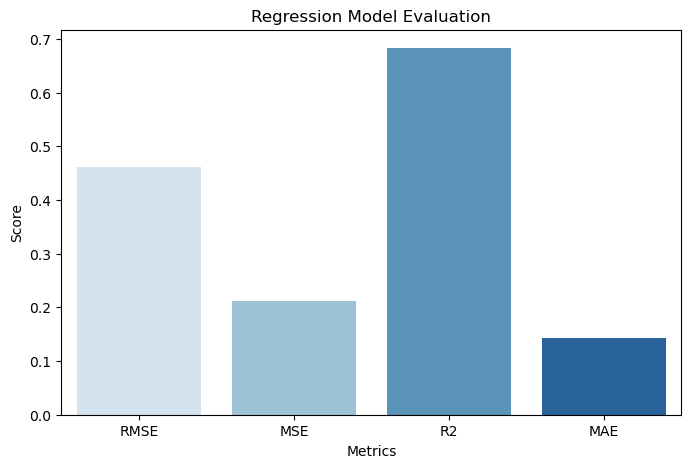

In [21]:
metrics = ["rmse", "mse", "r2", "mae"]
scores = {metric.upper(): RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName=metric).evaluate(predictions) for metric in metrics}

# Chuyển dữ liệu thành DataFrame Pandas
df_metrics = pd.DataFrame(scores.items(), columns=["Metric", "Score"])

# Vẽ biểu đồ Seaborn
plt.figure(figsize=(8, 5))
sns.barplot(x="Metric", y="Score", data=df_metrics, palette="Blues")
plt.title("Regression Model Evaluation")
plt.xlabel("Metrics")
plt.ylabel("Score")
plt.show()


In [23]:
multi_metrics = ["accuracy", "f1", "weightedPrecision", "weightedRecall"]
for metric in multi_metrics:
    evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName=metric)
    score = evaluator.evaluate(predictions)
    print(f"{metric.capitalize()}: {score}")

Accuracy: 0.8904109589041096
F1: 0.8906335840099849
Weightedprecision: 0.8927238274822991
Weightedrecall: 0.8904109589041096
